# Astronomy 406 "Computational Astrophysics" (Fall 2024)

# Project 3

### Background

In this project we explore different ways to test if two observed samples are consistent with being drawn from the same distribution function. These tests answer a basic question: are two samples consistent with each other? This question comes very often in astronomical observations of any objects, from planets to galaxies.

Read data from the file __gc.dat__ (located in Canvas/Files/Data), which contains measurements of three properties of old massive star clusters in our Galaxy: _metallicity [Fe/H]_ (which is the log10 of the ratio of iron abundance to its value in the Sun), _mass_ (in units of solar mass), and _distance from the center of the Galaxy_ (in kpc).

### Learning goals

* Learn various statistical tests to compare two distributions


* Acquire practical knowledge of assessing the probability of two samples being consistent


* Assess statistical significance of correlation between observed variables

# Part 1

1. Split the data into two sub-samples, with distance above and below 8 kpc, respectively. Then use log values of mass and distance. Let's call them _inner_ and _outer_ sub-samples. Remember that you are splitting objects, so all their properties (mass, distance, metallicity) split into their corresponding sub-samples.<br><br>

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [3]:
# load in metallicity, mass, and distance datasets
feh, m, d = np.loadtxt('gc.dat', unpack=True)

# split data into two populations based on distance
inner = d < 8
outer = d >= 8
log_m = np.log10(m)
log_d = np.log10(d)

# Part 2

2. Make a first visual assessment of the inner and outer sub-samples, by showing on the same plot the kernel density estimators (KDE, with the Epanechnikov kernel) of log mass for both sub-samples. Then a similar plot of [Fe/H] for both sub-samples. Do the two sub-samples look similar to each other? You can take the optimal bandwidth for KDE or investigate different bandwidths.<br><br>

In [4]:
# log(m) silverman's optimal h_0
percentile25 = pd.Series(log_m[inner]).quantile(0.25)
percentile75 = pd.Series(log_m[inner]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(log_m[inner])

h_0_log_m_inner = 0.9 * np.min([IQR / 1.34, sigma]) * len(log_m[inner]) ** (-1/5)
print('h_0 of log(m) inner:', round(h_0_log_m_inner, 4))



percentile25 = pd.Series(log_m[outer]).quantile(0.25)
percentile75 = pd.Series(log_m[outer]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(log_m[outer])

h_0_log_m_outer = 0.9 * np.min([IQR / 1.34, sigma]) * len(log_m[outer]) ** (-1/5)
print('h_0 of log(m) outer:', round(h_0_log_m_outer, 4))



# feh silverman's optimal h_0
percentile25 = pd.Series(feh[inner]).quantile(0.25)
percentile75 = pd.Series(feh[inner]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(feh[inner])

h_0_feh_inner = 0.9 * np.min([IQR / 1.34, sigma]) * len(feh[inner]) ** (-1/5)
print('h_0 of Fe/H inner:', round(h_0_feh_inner, 4))



percentile25 = pd.Series(feh[outer]).quantile(0.25)
percentile75 = pd.Series(feh[outer]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(feh[outer])

h_0_feh_outer = 0.9 * np.min([IQR / 1.34, sigma]) * len(feh[outer]) ** (-1/5)
print('h_0 of Fe/H outer:', round(h_0_feh_outer, 4))

h_0 of log(m) inner: 0.1448
h_0 of log(m) outer: 0.2931
h_0 of Fe/H inner: 0.2066
h_0 of Fe/H outer: 0.1377


In [5]:
# define Epanechnikov kernel
def K_Epan(u):
    if abs(u) <= 1:
        return .75 * (1 - u ** 2)
    else:
        return 0

def KDE_Epan_h(x, h, data):
    sum = 0
    N = len(feh) 
    # sum over all data points
    for i in range(len(data)):
        sum += (K_Epan(abs(x - data[i]) / h) / h)
    return sum / N

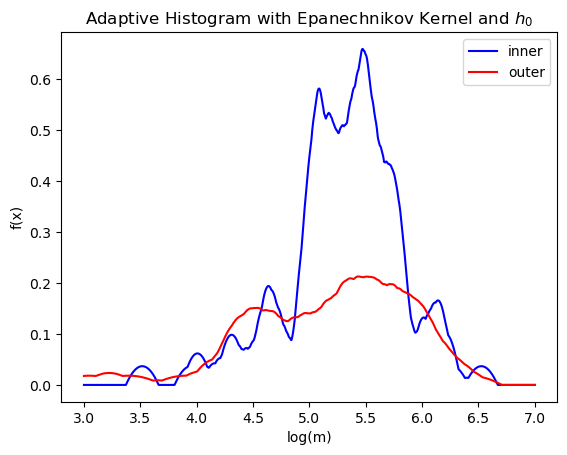

In [6]:
x_list = []
y_list_inner = []
y_list_outer = []
num_points = 1000

# loop over range of log(m) from 2 to 7
for x in np.linspace(3, 7, int(num_points)):
    x_list.append(x)
    y_list_inner.append(KDE_Epan_h(x, h_0_log_m_inner, log_m[inner]))
    y_list_outer.append(KDE_Epan_h(x, h_0_log_m_outer, log_m[outer]))

plt.plot(x_list, y_list_inner, color='b', label='inner')
plt.plot(x_list, y_list_outer, color='r', label='outer')
plt.xlabel('log(m)')
plt.ylabel('f(x)')
plt.title('Adaptive Histogram with Epanechnikov Kernel and $h_0$')
plt.legend()

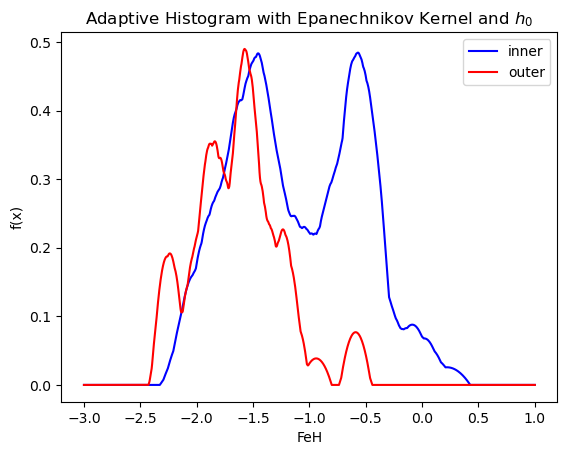

In [7]:
x_list = []
y_list_inner = []
y_list_outer = []
num_points = 1000

# loop over range of Fe/H from -3 to 1
for x in np.linspace(-3, 1, int(num_points)):
    x_list.append(x)
    y_list_inner.append(KDE_Epan_h(x, h_0_feh_inner, feh[inner]))
    y_list_outer.append(KDE_Epan_h(x, h_0_feh_outer, feh[outer]))

plt.plot(x_list, y_list_inner, color='b', label='inner')
plt.plot(x_list, y_list_outer, color='r', label='outer')
plt.xlabel('FeH')
plt.ylabel('f(x)')
plt.title('Adaptive Histogram with Epanechnikov Kernel and $h_0$')
plt.legend()

In the log of mass plot, the distributions look somewhat similar in terms of shape and mean, but the amplitude of the inner population is much greater than that of the outer population.

In the Fe/H plot, the distributions are very different; the inner population has a clearly bimodal distribution while the outer population only has one peak.

# Part 3

3. Evaluate whether the mass distribution of either sub-sample is consistent with being drawn from a normal distribution (with the same mean `mean` and standard deviation `std` as the sub-sample in question): run a one-sample Kolmogorov-Smirnov test using the SciPy routine [kstest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest) as `kstest(x, 'norm', args=(mean,std))`.<br><br>

In [8]:
print(stats.kstest(log_m[inner], 'norm', args=(np.mean(log_m[inner]), np.std(log_m[inner]))))
print(stats.kstest(log_m[outer], 'norm', args=(np.mean(log_m[outer]), np.std(log_m[outer]))))

KstestResult(statistic=0.10398134223396802, pvalue=0.26590510069323425, statistic_location=4.984977126415493, statistic_sign=-1)
KstestResult(statistic=0.1025517390856529, pvalue=0.6199160424268471, statistic_location=5.3404441148401185, statistic_sign=-1)


Both of these sub-samples look like they are somewhat consistent with being drawn from a normal distribution, as the KS test statistic is not very large, and the p values are not small/somewhat near 1. If the p value was small then that would suggest evidence against the null hypothesis that the sample is consistent with being drawn from a normal distribution, but they are not. In fact, the outer population's mass distribution is more similar to a normal distribution than the inner population's, and that is reflected in the larger p value for the outer sub-sample.

# Part 4

4. Evaluate whether the mass distributions of the two sub-samples are consistent with being drawn from the same distribution function, using Student's $t$ test of the means. And then same for [Fe/H].<br><br>


In [9]:
# log(m)
delta_inner = np.std(log_m[inner], ddof=1) / np.sqrt(len(log_m[inner]))
delta_outer = np.std(log_m[outer], ddof=1) / np.sqrt(len(log_m[outer]))

t = abs(np.mean(log_m[inner]) - np.mean(log_m[outer])) * (delta_inner ** 2 + delta_outer ** 2) ** (-1/2)
print(t)

# Fe/H
delta_inner = np.std(feh[inner], ddof=1) / np.sqrt(len(feh[inner]))
delta_outer = np.std(feh[outer], ddof=1) / np.sqrt(len(feh[outer]))

t = abs(np.mean(feh[inner]) - np.mean(feh[outer])) * (delta_inner ** 2 + delta_outer ** 2) ** (-1/2)
print(t)

1.1068244989181493
6.47383166998018


In [10]:
print(stats.ttest_ind(log_m[inner], log_m[outer], equal_var=False))
print(stats.ttest_ind(feh[inner], feh[outer], equal_var=False))

TtestResult(statistic=1.1068244989181495, pvalue=0.271701462710699, df=79.64846007429277)
TtestResult(statistic=6.47383166998018, pvalue=1.660462633034186e-09, df=134.08131341965992)


The t-test value is smaller for the mass distribution, indicating the inner and outer subpopulations are more similar to each other than the Fe/H distributions. This makes sense, as there is only one central population in each of the mass distributions, but differing numbers (1 vs. 2) of populations in the metallicity outer and inner distributions.

# Part 5

5. Evaluate whether the mass distributions of the two sub-samples are consistent with being drawn from the same distribution function, using the two-sample Kolmogorov-Smirnov test. And then same for [Fe/H]. What conclusions can you draw from the p-values of both tests?<br><br>

In [11]:
print(stats.ks_2samp(log_m[inner], log_m[outer]))
print(stats.ks_2samp(feh[inner], feh[outer]))

KstestResult(statistic=0.20588235294117646, pvalue=0.10712251289583521, statistic_location=4.948901760970213, statistic_sign=-1)
KstestResult(statistic=0.4300653594771242, pvalue=5.986512073210649e-06, statistic_location=-1.15, statistic_sign=-1)


Similarly, using the Kolmogorov-Smirnov test, the largest difference between the two distributions (inner and outer) is in the metallicity distributions, as expected. This means the outer and inner populations are more different in these distributions than they are in the mass distributions (as our other tests have also concluded). And from the p-values, we can tell the metallicity sub-samples are extremely different from each other, as the p-value is extremely small. The mass p-value is not as significant, so it is harder to draw a conclusion from that value.

# Concluding Assessment

Which numerical methods worked or did not work in this project:
* The kernel density estimators worked and really helped visualize the differences between the outer and inner subpopulations.
* Both the one and two sample Kolgorov-Smirnov tests helped to confirm what was visible by eye; that the subpopulations' mass distributions (outer and inner) were far more similar to each other than they were in metallicity. And that the inner population's mass distribution was more similar to being drawn from a normal distribution than the outer population was.
* The Student's t-test helped affirm that the two mass sub-samples' distributions seemed more likely to be drawn from the same distribution than the metallicity sub-samples did. The t-test value was too large (6.47) to be even considered similar distributions.

Lessons learned:
* These tests (Kolgorov-Smirnov and Student's t-test) both can help affirm or refute what we often assume just by looking at figures with our eyes. For example, these test helped confirm my guess that the metallicity distributions were much more different than each other, than the mass distributions were.
* I also learned about what p-value is, and how lower p-values mean it is more likely that the null hypothesis that two distributions are drawn from the same distribution/null hypothesis that a sample is drawn from a normal distribution is rejected.

Further code improvements I could have made with significantly more effort:
* I could have tried using more variants of the K-S test, like Anderson-Darling statistic, Kuiper's statistic, etc.
* I could have plotted the cumulative probability distribution to visualize the Kolgorov-Smirnov statistic as the greatest distance between the CDF and the theoretical distribution.